In [1]:
import pandas as pd
import krippendorff
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats import inter_rater as irr
from scipy.io.arff import loadarff
import numpy as np

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

def agreement_calculation(df, name_columns):
    results = []

    for i in name_columns:
        results.append(list(df[i]))
    
    unique = list(set([x for xs in results for x in xs]))
    le = LabelEncoder()
    le.fit(unique)

    if(len(results) <= 2):

        encod_rater1 = le.transform(results[0])
        encod_rater2 = le.transform(results[1])
        kappa_cohen = cohen_kappa_score(encod_rater1, encod_rater2)

        print("Kappa Cohen: ", kappa_cohen, "\n")

    else:

        print("Kappa Cohen:  There are more than two annotators! In this case, use Kappa Fleiss or Krippendorff's Alpha.\n")

    encod_rater = []

    for i in range(len(results)):
        encod_rater.append(le.transform(results[i]))

    giro = np.array(encod_rater).transpose()
    kappa_fleiss = irr.fleiss_kappa(irr.aggregate_raters(giro)[0], method='fleiss')

    print("Kappa Fleiss: ", kappa_fleiss, "\n")

    alpha = krippendorff.alpha(reliability_data=results, level_of_measurement="nominal")

    print("Krippendorff's alpha for nominal metric: ", alpha, "\n")
    
    return kappa_cohen

def trainer_fixed_pipeline(df_xtrain, df_xtest):
    df_ytrain = df_xtrain['class'].copy()
    df_xtrain = df_xtrain.drop(columns=['class'])
    df_ytest = df_xtest['class'].copy()
    df_xtest = df_xtest.drop(columns=['class'])
    
    rf = RandomForestClassifier(n_estimators=10).fit(df_xtrain, df_ytrain)
    y_pred_rf = rf.predict(df_xtest)
    print("Classification report RF: \n", classification_report(df_ytest, y_pred_rf))
    
    knn = KNeighborsClassifier().fit(df_xtrain, df_ytrain)
    y_pred_knn = knn.predict(df_xtest)
    print("Classification report KNN: \n", classification_report(df_ytest, y_pred_knn))
    
    nb = MultinomialNB().fit(df_xtrain, df_ytrain)
    y_pred_nb = nb.predict(df_xtest)
    print("Classification report NB: \n", classification_report(df_ytest, y_pred_nb))
    
    lr = LogisticRegression().fit(df_xtrain, df_ytrain)
    y_pred_lr = lr.predict(df_xtest)
    print("Classification report LR: \n", classification_report(df_ytest, y_pred_lr))
    
    vector = None
    
    return vector, rf, y_pred_rf, knn, y_pred_knn, nb, y_pred_nb, lr, y_pred_lr

In [2]:
df = pd.read_csv('datasets/pen-based/pen-based.csv')
df.drop(columns=['id'], inplace=True)

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.33, random_state=42)

df_xtrain = pd.concat([X_train, y_train], axis=1)
df_xtest = pd.concat([X_test, y_test], axis=1)

df_agreement = X_train.copy()
df_agreement['target'] = y_train
df_agreement['rater'] = y_train
df_agreement = df_agreement[['target', 'rater']]
df_agreement_aux = df_agreement.copy()

name_columns = [
    'target',
    'rater'
]

class_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

display(df_agreement)

,target,rater
1143,7,7
7692,0,0
4822,2,2
8744,9,9
9222,1,1
...,...,...
5734,8,8
5191,5,5
5390,2,2
860,2,2


# Agreement 1.0

In [3]:
kappa_100 = agreement_calculation(df_agreement, name_columns)

if kappa_100 == 1:
    vector100, rf100, y_pred_rf100, knn100, y_pred_knn100, nb100, y_pred_nb100, lr100, y_pred_lr100 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  1.0 

Kappa Fleiss:  1.0 

Krippendorff's alpha for nominal metric:  1.0 

Classification report RF: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       386
           1       0.97      0.97      0.97       381
           2       0.97      0.99      0.98       359
           3       0.99      0.99      0.99       377
           4       0.99      1.00      1.00       382
           5       0.99      0.99      0.99       345
           6       1.00      1.00      1.00       332
           7       0.98      0.98      0.98       350
           8       0.99      0.99      0.99       349
           9       0.98      0.99      0.98       367

    accuracy                           0.99      3628
   macro avg       0.99      0.99      0.99      3628
weighted avg       0.99      0.99      0.99      3628

Classification report KNN: 
               precision    recall  f1-score   support

           0       0.99      1.00      1

# Agreement 0.90

In [4]:
df_agreement = df_agreement_aux.copy()

for i in range(600):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_90 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_90 >= 0.88) and (kappa_90 <= 0.92):
    vector90, rf90, y_pred_rf90, knn90, y_pred_knn90, nb90, y_pred_nb90, lr90, y_pred_lr90 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.9094415282164326 

Kappa Fleiss:  0.9094413342572433 

Krippendorff's alpha for nominal metric:  0.9094474829988064 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       386
           1       0.96      0.94      0.95       381
           2       0.95      0.99      0.97       359
           3       0.98      0.98      0.98       377
           4       0.98      1.00      0.99       382
           5       0.99      0.98      0.99       345
           6       0.99      0.99      0.99       332
           7       0.98      0.97      0.97       350
           8       0.98      0.98      0.98       349
           9       0.99      0.97      0.98       367

    accuracy                           0.98      3628
   macro avg       0.98      0.98      0.98      3628
weighted avg       0.98      0.98      0.98      3628

Classification report KNN: 
               precision    recall  f1-score   supp

# Agreement 0.80

In [5]:
df_agreement = df_agreement_aux.copy()

for i in range(1250):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_80 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_80 >= 0.78) and (kappa_80 <= 0.82):
    vector80, rf80, y_pred_rf80, knn80, y_pred_knn80, nb80, y_pred_nb80, lr80, y_pred_lr80 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.8113410489003181 

Kappa Fleiss:  0.8113390343718964 

Krippendorff's alpha for nominal metric:  0.8113518440518006 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       386
           1       0.92      0.93      0.92       381
           2       0.92      0.96      0.94       359
           3       0.98      0.95      0.96       377
           4       0.97      0.96      0.97       382
           5       0.95      0.92      0.93       345
           6       0.94      0.96      0.95       332
           7       0.95      0.97      0.96       350
           8       0.97      0.96      0.97       349
           9       0.97      0.94      0.95       367

    accuracy                           0.95      3628
   macro avg       0.95      0.95      0.95      3628
weighted avg       0.95      0.95      0.95      3628

Classification report KNN: 
               precision    recall  f1-score   supp

# Agreement 0.70

In [6]:
df_agreement = df_agreement_aux.copy()

for i in range(2000):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_70 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_70 >= 0.68) and (kappa_70 <= 0.72):
    vector70, rf70, y_pred_rf70, knn70, y_pred_knn70, nb70, y_pred_nb70, lr70, y_pred_lr70 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.6981576426226658 

Kappa Fleiss:  0.6981528019256162 

Krippendorff's alpha for nominal metric:  0.6981732967109282 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       386
           1       0.88      0.85      0.86       381
           2       0.85      0.92      0.88       359
           3       0.91      0.92      0.91       377
           4       0.92      0.88      0.90       382
           5       0.86      0.87      0.87       345
           6       0.89      0.89      0.89       332
           7       0.88      0.88      0.88       350
           8       0.90      0.91      0.90       349
           9       0.90      0.81      0.85       367

    accuracy                           0.88      3628
   macro avg       0.88      0.88      0.88      3628
weighted avg       0.88      0.88      0.88      3628

Classification report KNN: 
               precision    recall  f1-score   supp

# Agreement 0.60

In [7]:
df_agreement = df_agreement_aux.copy()

for i in range(2600):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_60 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_60 >= 0.58) and (kappa_60 <= 0.62):
    vector60, rf60, y_pred_rf60, knn60, y_pred_knn60, nb60, y_pred_nb60, lr60, y_pred_lr60 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.6076097202956814 

Kappa Fleiss:  0.6076012843421632 

Krippendorff's alpha for nominal metric:  0.6076279273836934 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.74      0.82      0.78       386
           1       0.79      0.75      0.77       381
           2       0.75      0.84      0.79       359
           3       0.85      0.83      0.84       377
           4       0.83      0.83      0.83       382
           5       0.80      0.76      0.78       345
           6       0.77      0.82      0.80       332
           7       0.82      0.79      0.80       350
           8       0.80      0.83      0.82       349
           9       0.82      0.69      0.75       367

    accuracy                           0.79      3628
   macro avg       0.80      0.80      0.79      3628
weighted avg       0.80      0.79      0.79      3628

Classification report KNN: 
               precision    recall  f1-score   supp

# Agreement 0.50

In [8]:
df_agreement = df_agreement_aux.copy()

for i in range(3200):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_50 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_50 >= 0.48) and (kappa_50 <= 0.52):
    vector50, rf50, y_pred_rf50, knn50, y_pred_knn50, nb50, y_pred_nb50, lr50, y_pred_lr50 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.5170913310487826 

Kappa Fleiss:  0.517069969265285 

Krippendorff's alpha for nominal metric:  0.5171027591913262 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.58      0.63      0.60       386
           1       0.62      0.63      0.62       381
           2       0.63      0.66      0.64       359
           3       0.68      0.71      0.69       377
           4       0.72      0.72      0.72       382
           5       0.68      0.67      0.67       345
           6       0.65      0.63      0.64       332
           7       0.64      0.63      0.64       350
           8       0.67      0.72      0.69       349
           9       0.67      0.52      0.58       367

    accuracy                           0.65      3628
   macro avg       0.65      0.65      0.65      3628
weighted avg       0.65      0.65      0.65      3628

Classification report KNN: 
               precision    recall  f1-score   suppo

# Agreement 0.40

In [9]:
df_agreement = df_agreement_aux.copy()

for i in range(3850):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_40 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_40 >= 0.38) and (kappa_40 <= 0.42):
    vector40, rf40, y_pred_rf40, knn40, y_pred_knn40, nb40, y_pred_nb40, lr40, y_pred_lr40 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.41900031716712727 

Kappa Fleiss:  0.41896986517661694 

Krippendorff's alpha for nominal metric:  0.41900931589190915 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.45      0.52      0.48       386
           1       0.50      0.50      0.50       381
           2       0.53      0.58      0.55       359
           3       0.56      0.53      0.54       377
           4       0.57      0.62      0.59       382
           5       0.53      0.46      0.49       345
           6       0.51      0.57      0.54       332
           7       0.56      0.53      0.55       350
           8       0.54      0.54      0.54       349
           9       0.44      0.33      0.38       367

    accuracy                           0.52      3628
   macro avg       0.52      0.52      0.52      3628
weighted avg       0.52      0.52      0.52      3628

Classification report KNN: 
               precision    recall  f1-score   s

# Agreement 0.30

In [10]:
df_agreement = df_agreement_aux.copy()

for i in range(4600):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_30 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_30 >= 0.28) and (kappa_30 <= 0.32):
    vector30, rf30, y_pred_rf30, knn30, y_pred_knn30, nb30, y_pred_nb30, lr30, y_pred_lr30 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.30586440725200625 

Kappa Fleiss:  0.30580847458613564 

Krippendorff's alpha for nominal metric:  0.3058556087201264 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.30      0.34      0.32       386
           1       0.34      0.34      0.34       381
           2       0.39      0.43      0.41       359
           3       0.39      0.36      0.38       377
           4       0.38      0.39      0.39       382
           5       0.35      0.37      0.36       345
           6       0.34      0.33      0.34       332
           7       0.34      0.33      0.34       350
           8       0.35      0.36      0.35       349
           9       0.21      0.16      0.18       367

    accuracy                           0.34      3628
   macro avg       0.34      0.34      0.34      3628
weighted avg       0.34      0.34      0.34      3628

Classification report KNN: 
               precision    recall  f1-score   su

# Agreement 0.20

In [11]:
df_agreement = df_agreement_aux.copy()

for i in range(5200):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_20 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_20 >= 0.18) and (kappa_20 <= 0.22):
    vector20, rf20, y_pred_rf20, knn20, y_pred_knn20, nb20, y_pred_nb20, lr20, y_pred_lr20 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.21535763746358294 

Kappa Fleiss:  0.21526351482444595 

Krippendorff's alpha for nominal metric:  0.21531679676939264 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.21      0.23      0.22       386
           1       0.20      0.19      0.19       381
           2       0.24      0.27      0.25       359
           3       0.25      0.23      0.24       377
           4       0.22      0.21      0.22       382
           5       0.18      0.20      0.19       345
           6       0.22      0.23      0.22       332
           7       0.21      0.20      0.20       350
           8       0.24      0.26      0.25       349
           9       0.11      0.09      0.10       367

    accuracy                           0.21      3628
   macro avg       0.21      0.21      0.21      3628
weighted avg       0.21      0.21      0.21      3628

Classification report KNN: 
               precision    recall  f1-score   s

# Agreement 0.10

In [12]:
df_agreement = df_agreement_aux.copy()

for i in range(5900):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_10 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if (kappa_10 >= 0.08) and (kappa_10 <= 0.12):
    vector10, rf10, y_pred_rf10, knn10, y_pred_knn10, nb10, y_pred_nb10, lr10, y_pred_lr10 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.10980707091129727 

Kappa Fleiss:  0.10964517892289334 

Krippendorff's alpha for nominal metric:  0.10970563212910456 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.09      0.10      0.09       386
           1       0.08      0.08      0.08       381
           2       0.16      0.19      0.17       359
           3       0.07      0.06      0.07       377
           4       0.06      0.06      0.06       382
           5       0.07      0.08      0.08       345
           6       0.09      0.10      0.10       332
           7       0.11      0.10      0.11       350
           8       0.11      0.11      0.11       349
           9       0.04      0.04      0.04       367

    accuracy                           0.09      3628
   macro avg       0.09      0.09      0.09      3628
weighted avg       0.09      0.09      0.09      3628

Classification report KNN: 
               precision    recall  f1-score   s

# Agreement 0.00

In [13]:
df_agreement = df_agreement_aux.copy()

for i in range(6500):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_0 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if kappa_0 <= 0.02:
    vector0, rf0, y_pred_rf0, knn0, y_pred_knn0, nb0, y_pred_nb0, lr0, y_pred_lr0 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  0.01924308744226677 

Kappa Fleiss:  0.01908114240671801 

Krippendorff's alpha for nominal metric:  0.019147744719156257 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.02      0.02      0.02       386
           1       0.03      0.03      0.03       381
           2       0.08      0.09      0.08       359
           3       0.02      0.02      0.02       377
           4       0.01      0.01      0.01       382
           5       0.04      0.05      0.05       345
           6       0.02      0.02      0.02       332
           7       0.04      0.03      0.03       350
           8       0.04      0.04      0.04       349
           9       0.01      0.01      0.01       367

    accuracy                           0.03      3628
   macro avg       0.03      0.03      0.03      3628
weighted avg       0.03      0.03      0.03      3628

Classification report KNN: 
               precision    recall  f1-score   

# Disagreement

In [14]:
df_agreement = df_agreement_aux.copy()

for i in range(len(df_agreement)):
    for j in range(len(class_list)):
        if(df_agreement['rater'].iloc[i] == 9):
            df_agreement['rater'].iloc[i] = 0
            break
        if(df_agreement['rater'].iloc[i] == class_list[j]):
            df_agreement['rater'].iloc[i] = class_list[j+1]
            break

kappa_00 = agreement_calculation(df_agreement, name_columns)
df_xtrain['class'] = df_agreement['rater']

if kappa_00 <= 0.02:
    vector00, rf00, y_pred_rf00, knn00, y_pred_knn00, nb00, y_pred_nb00, lr00, y_pred_lr00 = trainer_fixed_pipeline(df_xtrain, df_xtest)

Kappa Cohen:  -0.11100148980355895 

Kappa Fleiss:  -0.11122382352907426 

Krippendorff's alpha for nominal metric:  -0.11114837378548859 

Classification report RF: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       386
           1       0.00      0.00      0.00       381
           2       0.02      0.02      0.02       359
           3       0.00      0.00      0.00       377
           4       0.00      0.00      0.00       382
           5       0.00      0.00      0.00       345
           6       0.00      0.00      0.00       332
           7       0.00      0.00      0.00       350
           8       0.01      0.01      0.01       349
           9       0.00      0.00      0.00       367

    accuracy                           0.00      3628
   macro avg       0.00      0.00      0.00      3628
weighted avg       0.00      0.00      0.00      3628

Classification report KNN: 
               precision    recall  f1-score 

# Comparison of metrics

In [15]:
agreements = ['< 0', 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [16]:
rf_f1_100 = f1_score(y_test, y_pred_rf100, average='macro')
rf_f1_90 = f1_score(y_test, y_pred_rf90, average='macro')
rf_f1_80 = f1_score(y_test, y_pred_rf80, average='macro')
rf_f1_70 = f1_score(y_test, y_pred_rf70, average='macro')
rf_f1_60 = f1_score(y_test, y_pred_rf60, average='macro')
rf_f1_50 = f1_score(y_test, y_pred_rf50, average='macro')
rf_f1_40 = f1_score(y_test, y_pred_rf40, average='macro')
rf_f1_30 = f1_score(y_test, y_pred_rf30, average='macro')
rf_f1_20 = f1_score(y_test, y_pred_rf20, average='macro')
rf_f1_10 = f1_score(y_test, y_pred_rf10, average='macro')
rf_f1_0 = f1_score(y_test, y_pred_rf0, average='macro')
rf_f1_00 = f1_score(y_test, y_pred_rf00, average='macro')

rf_f1 = [rf_f1_100, rf_f1_90, rf_f1_80, rf_f1_70, rf_f1_60, rf_f1_50, rf_f1_40, rf_f1_30, rf_f1_20, 
         rf_f1_10, rf_f1_0, rf_f1_00]

rf_f1 = rf_f1[::-1]

In [17]:
knn_f1_100 = f1_score(y_test, y_pred_knn100, average='macro')
knn_f1_90 = f1_score(y_test, y_pred_knn90, average='macro')
knn_f1_80 = f1_score(y_test, y_pred_knn80, average='macro')
knn_f1_70 = f1_score(y_test, y_pred_knn70, average='macro')
knn_f1_60 = f1_score(y_test, y_pred_knn60, average='macro')
knn_f1_50 = f1_score(y_test, y_pred_knn50, average='macro')
knn_f1_40 = f1_score(y_test, y_pred_knn40, average='macro')
knn_f1_30 = f1_score(y_test, y_pred_knn30, average='macro')
knn_f1_20 = f1_score(y_test, y_pred_knn20, average='macro')
knn_f1_10 = f1_score(y_test, y_pred_knn10, average='macro')
knn_f1_0 = f1_score(y_test, y_pred_knn0, average='macro')
knn_f1_00 = f1_score(y_test, y_pred_knn00, average='macro')

knn_f1 = [knn_f1_100, knn_f1_90, knn_f1_80, knn_f1_70, knn_f1_60, knn_f1_50, knn_f1_40, knn_f1_30, knn_f1_20, 
         knn_f1_10, knn_f1_0, knn_f1_00]

knn_f1 = knn_f1[::-1]

In [18]:
nb_f1_100 = f1_score(y_test, y_pred_nb100, average='macro')
nb_f1_90 = f1_score(y_test, y_pred_nb90, average='macro')
nb_f1_80 = f1_score(y_test, y_pred_nb80, average='macro')
nb_f1_70 = f1_score(y_test, y_pred_nb70, average='macro')
nb_f1_60 = f1_score(y_test, y_pred_nb60, average='macro')
nb_f1_50 = f1_score(y_test, y_pred_nb50, average='macro')
nb_f1_40 = f1_score(y_test, y_pred_nb40, average='macro')
nb_f1_30 = f1_score(y_test, y_pred_nb30, average='macro')
nb_f1_20 = f1_score(y_test, y_pred_nb20, average='macro')
nb_f1_10 = f1_score(y_test, y_pred_nb10, average='macro')
nb_f1_0 = f1_score(y_test, y_pred_nb0, average='macro')
nb_f1_00 = f1_score(y_test, y_pred_nb00, average='macro')

nb_f1 = [nb_f1_100, nb_f1_90, nb_f1_80, nb_f1_70, nb_f1_60, nb_f1_50, nb_f1_40, nb_f1_30, nb_f1_20, 
         nb_f1_10, nb_f1_0, nb_f1_00]

nb_f1 = nb_f1[::-1]

In [19]:
lr_f1_100 = f1_score(y_test, y_pred_lr100, average='macro')
lr_f1_90 = f1_score(y_test, y_pred_lr90, average='macro')
lr_f1_80 = f1_score(y_test, y_pred_lr80, average='macro')
lr_f1_70 = f1_score(y_test, y_pred_lr70, average='macro')
lr_f1_60 = f1_score(y_test, y_pred_lr60, average='macro')
lr_f1_50 = f1_score(y_test, y_pred_lr50, average='macro')
lr_f1_40 = f1_score(y_test, y_pred_lr40, average='macro')
lr_f1_30 = f1_score(y_test, y_pred_lr30, average='macro')
lr_f1_20 = f1_score(y_test, y_pred_lr20, average='macro')
lr_f1_10 = f1_score(y_test, y_pred_lr10, average='macro')
lr_f1_0 = f1_score(y_test, y_pred_lr0, average='macro')
lr_f1_00 = f1_score(y_test, y_pred_lr00, average='macro')

lr_f1 = [lr_f1_100, lr_f1_90, lr_f1_80, lr_f1_70, lr_f1_60, lr_f1_50, lr_f1_40, lr_f1_30, lr_f1_20, 
         lr_f1_10, lr_f1_0, lr_f1_00]

lr_f1 = lr_f1[::-1]

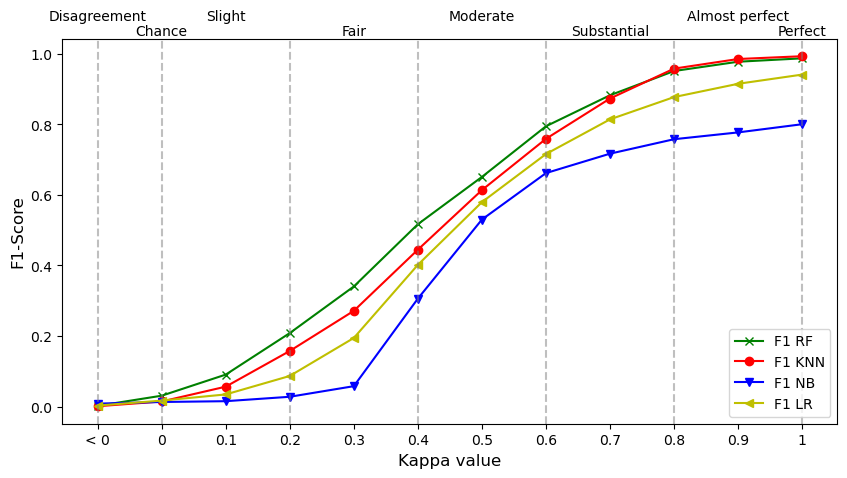

In [21]:
# Plot a simple line chart
plt.plot(agreements, rf_f1, 'g', label='F1 RF', marker='x')
plt.plot(agreements, knn_f1, 'r', label='F1 KNN', marker='o')
plt.plot(agreements, nb_f1, 'b', label='F1 NB', marker='v')
plt.plot(agreements, lr_f1, 'y', label='F1 LR', marker='<')

plt.axvline(x=0, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=1, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=3, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=5, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=7, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=9, linestyle='dashed', color='gray', alpha=0.5)
plt.axvline(x=11, linestyle='dashed', color='gray', alpha=0.5)

y_pos = plt.ylim()[1]

plt.text(0, y_pos * 1.05, 'Disagreement', color='black', ha='center')
plt.text(1, y_pos * 1.01, 'Chance', color='black', ha='center')
plt.text(2, y_pos * 1.05, 'Slight', color='black', ha='center')
plt.text(4, y_pos * 1.01, 'Fair', color='black', ha='center')
plt.text(6, y_pos * 1.05, 'Moderate', color='black', ha='center')
plt.text(8, y_pos * 1.01, 'Substantial', color='black', ha='center')
plt.text(10, y_pos * 1.05, 'Almost perfect', color='black', ha='center')
plt.text(11, y_pos * 1.01, 'Perfect', color='black', ha='center')

plt.legend()
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams.update({'font.size': 10})

plt.xlabel('Kappa value', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)

plt.show()